# Better Model

# Time Series Split and Cross validation

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import ta  # Technical Analysis library
from sklearn.model_selection import TimeSeriesSplit



import trading_utils as trading_utils

In [30]:
# 1. Download Data: MSCI World (URTH ETF) and S&P 500 (SPY ETF)
start_date = "2015-01-01"
end_date = "2023-12-31"
msci = yf.download("URTH", start=start_date, end=end_date)
sp500 = yf.download("SPY", start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [31]:


msci_flat = msci.copy()
msci_flat.columns = [col[0] for col in msci_flat.columns]  # flatten MultiIndex to single level

# The error occurs because after flattening, msci_flat.columns are already single-level (e.g., 'Close', 'High', etc.).
# The rename step is unnecessary and actually removes the 'Close' column if it doesn't match.
# Just pass msci_flat directly to add_advanced_features.

# Use 'Close' instead of 'Adj Close' since msci_flat columns are ['Close', 'High', 'Low', 'Open', 'Volume']
def add_advanced_features(df):
    df = df.copy()
    df['Return'] = df['Close'].pct_change()
    df['MA5'] = df['Close'].rolling(window=5).mean()
    df['MA10'] = df['Close'].rolling(window=10).mean()
    df['MA20'] = df['Close'].rolling(window=20).mean()
    df['STD5'] = df['Close'].rolling(window=5).std()
    df['RSI'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()
    df['MACD'] = ta.trend.MACD(df['Close']).macd()
    df['BB_High'] = ta.volatility.BollingerBands(df['Close']).bollinger_hband()
    df['BB_Low'] = ta.volatility.BollingerBands(df['Close']).bollinger_lband()
    df['ATR'] = ta.volatility.AverageTrueRange(df['High'], df['Low'], df['Close']).average_true_range()
    df = df.dropna()
    return df

msci_feat_adv = add_advanced_features(msci_flat)

# 2. Prepare Data: Use more features, align y
features_adv = ['MA5', 'MA10', 'MA20', 'STD5', 'RSI', 'MACD', 'BB_High', 'BB_Low', 'ATR']
X_adv = msci_feat_adv[features_adv].values
y_adv = (msci_feat_adv['Return'].shift(-1) > 0).astype(int).values[:-1]
X_adv = X_adv[:-1]


In [32]:

# 3. Time Series Split: Use only past data for training, future for testing

scaler_adv = StandardScaler()
X_adv_scaled = scaler_adv.fit_transform(X_adv)

tscv = TimeSeriesSplit(n_splits=4)
fold = 1
val_scores = []
for train_idx, test_idx in tscv.split(X_adv_scaled):
    print(f"\nFold {fold}:")
    X_train_cv, X_test_cv = X_adv_scaled[train_idx], X_adv_scaled[test_idx]
    y_train_cv, y_test_cv = y_adv[train_idx], y_adv[test_idx]

    # 4. Improved Model: Add Dropout, BatchNorm, more layers
    model_cv = keras.Sequential([
        keras.layers.Dense(128, activation='relu', input_shape=(X_train_cv.shape[1],)),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    model_cv.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # 5. Early Stopping
    es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history_cv = model_cv.fit(
        X_train_cv, y_train_cv,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        callbacks=[es],
        verbose=0
    )

    # 6. Evaluate
    loss_cv, acc_cv = model_cv.evaluate(X_test_cv, y_test_cv, verbose=0)
    print(f"Validation Accuracy: {acc_cv:.3f}")
    val_scores.append(acc_cv)
    fold += 1

print(f"\nAverage 4-Fold Validation Accuracy: {np.mean(val_scores):.3f}")


/Users/simonadrianomunozlagunas/Desktop/Projects/Trading/trading_venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Fold 1:
Validation Accuracy: 0.577

Fold 2:
Validation Accuracy: 0.555

Fold 3:
Validation Accuracy: 0.463

Fold 4:
Validation Accuracy: 0.517

Average 4-Fold Validation Accuracy: 0.528


In [33]:

# 7. Final Model: Train on all but last fold, test on last fold (future data)
train_idx, test_idx = list(tscv.split(X_adv_scaled))[-1]
X_train_final, X_test_final = X_adv_scaled[train_idx], X_adv_scaled[test_idx]
y_train_final, y_test_final = y_adv[train_idx], y_adv[test_idx]

final_model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X_train_final.shape[1],)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
final_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
es_final = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history_final = final_model.fit(
    X_train_final, y_train_final,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[es_final],
    verbose=1
)

loss_final, acc_final = final_model.evaluate(X_test_final, y_test_final)
print(f"\nTest Accuracy on Future Data: {acc_final:.3f}")



Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5260 - loss: 0.7462 - val_accuracy: 0.5515 - val_loss: 0.6908
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5393 - loss: 0.7142 - val_accuracy: 0.5599 - val_loss: 0.6931
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5559 - loss: 0.7031 - val_accuracy: 0.5543 - val_loss: 0.6975
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5617 - loss: 0.6947 - val_accuracy: 0.5627 - val_loss: 0.6967
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5540 - loss: 0.6911 - val_accuracy: 0.5348 - val_loss: 0.6991
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5447 - loss: 0.6997 - val_accuracy: 0.5209 - val_loss: 0.6981
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4897 - loss: 0.6988 

Test Accuracy on Future Data: 0.512


In [34]:
# 8. Backtest Improved Strategy
msci_feat_adv = msci_feat_adv.iloc[:-1]
msci_feat_adv['Pred'] = final_model.predict(X_adv_scaled).flatten() > 0.5 
msci_feat_adv['Strategy'] = msci_feat_adv['Pred'].shift(1) * msci_feat_adv['Return']
msci_feat_adv['Strategy'].fillna(0, inplace=True)
msci_feat_adv['Cumulative_Strategy'] = (1 + msci_feat_adv['Strategy']).cumprod()
msci_feat_adv['Cumulative_MSCI'] = (1 + msci_feat_adv['Return']).cumprod()


70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step


/var/folders/s4/0750y7y93tb7d2vxv6r614rm0000gn/T/ipykernel_72729/452422228.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  msci_feat_adv['Strategy'].fillna(0, inplace=True)
/var/folders/s4/0750y7y93tb7d2vxv6r614rm0000gn/T/ipykernel_72729/452422228.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  msci_fea

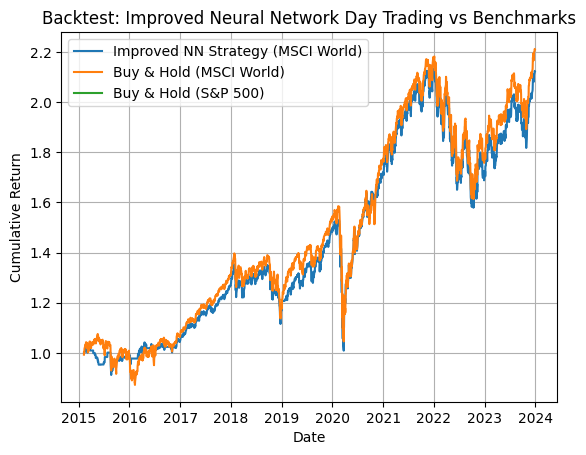


Improvements made:
- Added more technical indicators (MACD, Bollinger Bands, ATR) for richer features.
- Used TimeSeriesSplit for 4-fold cross-validation, ensuring only past data is used for training and future data for testing.
- Enhanced neural network with more layers, BatchNormalization, and Dropout to reduce overfitting.
- Used EarlyStopping to avoid overtraining.
- Final model is trained on all but the last fold and tested on the last (future) fold for realistic performance.



In [ ]:

# 9. Plot Improved Results
# Calculate S&P 500 cumulative returns for Buy & Hold
sp500['Return_SP500'] = sp500['Close'].pct_change().fillna(0)
sp500['Cumulative_SP500'] = (1 + sp500['Return_SP500']).cumprod()
plt.plot(msci_feat_adv.index, msci_feat_adv['Cumulative_Strategy'], label='Improved NN Strategy (MSCI World)')
plt.plot(msci_feat_adv.index, msci_feat_adv['Cumulative_MSCI'], label='Buy & Hold (MSCI World)')
plt.plot(sp500.index, sp500['Cumulative_SP500'], label='Buy & Hold (S&P 500)')
plt.title('Backtest: Improved Neural Network Day Trading vs Benchmarks')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid()
#plt.savefig("improved_strategy_vs_benchmarks.png", dpi=200, bbox_inches='tight')
plt.show()

# 10. Explanation of Improvements
print("""
Improvements made:
- Added more technical indicators (MACD, Bollinger Bands, ATR) for richer features.
- Used TimeSeriesSplit for 4-fold cross-validation, ensuring only past data is used for training and future data for testing.
- Enhanced neural network with more layers, BatchNormalization, and Dropout to reduce overfitting.
- Used EarlyStopping to avoid overtraining.
- Final model is trained on all but the last fold and tested on the last (future) fold for realistic performance.
""")